<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#3)-Visualization-of-the-variables" data-toc-modified-id="3)-Visualization-of-the-variables-1">3) Visualization of the variables</a></span><ul class="toc-item"><li><span><a href="#Interactive-world-map" data-toc-modified-id="Interactive-world-map-1.1">Interactive world map</a></span></li><li><span><a href="#Sankey-plot:-World-regions-and-attack-succes" data-toc-modified-id="Sankey-plot:-World-regions-and-attack-succes-1.2">Sankey plot: World regions and attack succes</a></span></li><li><span><a href="#Attack-location-distribution" data-toc-modified-id="Attack-location-distribution-1.3">Attack location distribution</a></span></li><li><span><a href="#Attacks-by-month,-weekday-and-time-of-day" data-toc-modified-id="Attacks-by-month,-weekday-and-time-of-day-1.4">Attacks by month, weekday and time of day</a></span></li></ul></li></ul></div>

## 3) Visualization of the variables

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

from bokeh.palettes import brewer
from bokeh.tile_providers import CARTODBPOSITRON_RETINA, get_provider
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, NumeralTickFormatter, RangeTool, Range1d
from bokeh.models import DataRange1d, Plot, LinearAxis, Grid, Legend, LegendItem
from bokeh.core.enums import LegendLocation
from bokeh.io import output_notebook, curdoc, show
from bokeh.models.glyphs import Step
import panel as pn
from plotly import graph_objs as go

from sklearn.preprocessing import LabelEncoder

plt.style.use("seaborn-white")
plt.rcParams["font.size"] = 14
colors = sns.color_palette("Paired")

In [12]:
pirate_data = pd.read_csv(f"data/pirate_data_cleaned.csv", index_col = 0)
pirate_data['DATE (LT)'] = pd.to_datetime(pirate_data['DATE (LT)'])
pirate_data.head()

,DATE (LT),REGION,COUNTRY,INCIDENT TYPE,VESSEL TYPE,MAERSK?,VESSEL ACTIVITY LOCATION,LAT,LONG,TIME OF DAY,ATTACKS,ATTACK SUCCESS,YEAR,MONTH,WEEK,DAY,WEEKDAY,YEAR_MONTH
703,2015-01-04,East Africa,Djibouti,Suspicious activity at sea,Merchant vessel,0,Off shore,12.553333,43.426667,Unknown,1,0,2015,1,1,4,6,2015-01
702,2015-01-04,South East Asia,Singapore,Theft at sea,Tug,0,Off shore,1.324500,104.541500,Morning,1,1,2015,1,1,4,6,2015-01
701,2015-01-04,North Africa,Libya,Other maritime risk,Crude oil tanker,0,Anchorage,32.780116,22.663078,Afternoon,1,1,2015,1,1,4,6,2015-01
700,2015-01-06,East Africa,Djibouti,Suspicious activity at sea,Merchant vessel,0,Off shore,13.253333,42.956667,Afternoon,1,0,2015,1,2,6,1,2015-01
699,2015-01-07,West Africa,Nigeria,Kidnap/ransom at anchorage,Unknown vessel type,0,Anchorage,4.638297,6.812897,Unknown,1,1,2015,1,2,7,2,2015-01


### Interactive world map

Since we have information on the latitude and longitude of all the attacks, they can be visualized nicely on a world map. Maybe we can gain some insights into where attacks are more likely to be successful.

In [50]:
# from http://wiki.openstreetmap.org/wiki/Mercator#Java

RADIUS = 6378137.0; # in meters on the equator
def y2lat(aY):
    return math.degrees(math.atan(math.exp(aY / RADIUS)) * 2 - math.pi/2);
def x2lon( aX):
    return math.degrees(aX / RADIUS);
# These functions take their angle parameter in degrees and return a length in meters

def lat2y(a):
    return math.log(math.tan(math.pi / 4 + math.radians(a) / 2)) * RADIUS
def lon2x(a):
    return math.radians(a) * RADIUS

pirate_data['X'] = pirate_data['LONG'].apply(lambda x: lon2x(x))
pirate_data['Y'] = pirate_data['LAT'].apply(lambda x: lat2y(x))
pirate_data["datestring"] = pirate_data["DATE (LT)"].map(lambda x: x.strftime('%Y-%m-%d'))
cols =  {0: brewer["Paired"][12][1], 1: brewer["Paired"][12][6]}
pirate_data["color"] = pirate_data["ATTACK SUCCESS"].apply(lambda c: cols[c])

In [74]:
pn.extension()
output_notebook()

# First define the widgets for dropdowns
years = ["All"] + sorted(pd.unique(pirate_data['YEAR']))
year = pn.widgets.Select(name='Year', options=years)

outcomes = ["All"] + ["Successful"] + ["Failed"]
outcome = pn.widgets.Select(name='Outcome', options = outcomes)

# Define the plotting function for the panel
@pn.depends(year.param.value, outcome.param.value)
def get_plot(year, outcome):
    if year == "All":
        group = pirate_data
    else:    
        group = pirate_data[pirate_data['YEAR'] == year]
    
    if outcome == "All":
        group = group
    elif outcome == "Successful":
        group = group[group['ATTACK SUCCESS'] == 1]
    else:    
        group = group[group['ATTACK SUCCESS'] == 0]

    cds = ColumnDataSource(group)
    TOOLTIPS = [("Date", "@datestring"),
           ("Country", "@COUNTRY"),
           ("Incident", "@{INCIDENT TYPE}"),
           ("Vessel","@{VESSEL TYPE}")]
    
    p = figure(x_range = Range1d(lon2x(-130), lon2x(180)), 
           y_range = Range1d(lat2y(-60), lat2y(60)),
           x_axis_type="mercator", y_axis_type="mercator", plot_width=800, plot_height=500,
           tools = "pan, wheel_zoom, reset, hover", tooltips = TOOLTIPS)
    tile_provider = get_provider(CARTODBPOSITRON_RETINA)
    p.add_tile(tile_provider)
    p.circle('X', 'Y', source = cds, alpha = 0.5, color = "color", size = 5)
    
    p.title.text = "Pirate attacks by location"
    p.title.text_font_size = "20px"
    p.axis.ticker = []
    p.axis.visible = False
    return p

# Then call the function inside the panel structure
pn.Column(get_plot, pn.Row(outcome, year)).servable()

# Limit scrolling out

Loading BokehJS ...

Column
    [0] ParamFunction(function)
    [1] Row
        [0] Select(name='Outcome', options=['All', 'Successful', ...], value='All')
        [1] Select(name='Year', options=['All', 2015, 2016], value='All')

### Sankey plot: World regions and attack succes

The following diagram shows the proportions of successful (Outcome 1) and unsuccessful (Outcome 0) attacks per world region.

In [15]:
le = LabelEncoder()
pirate_data['REGION_NR'] = le.fit_transform(pirate_data['REGION'])

sd_attacks = pirate_data.groupby(["ATTACK SUCCESS", "REGION_NR"]).size().reset_index(name="value")
sd_attacks['REGION_NR'] = sd_attacks['REGION_NR'] + len(sd_attacks["ATTACK SUCCESS"].unique())

sd_labels =  ['Outcome ' + str(i) for i in 
                                 range(len(sd_attacks["ATTACK SUCCESS"].unique()))] + list(le.classes_)

fig = go.Figure(
    data = [go.Sankey(
        node = dict(label = sd_labels), 
        link = dict(source = list(sd_attacks["ATTACK SUCCESS"]), target = list(sd_attacks['REGION_NR']), 
                    value = list(sd_attacks["value"])),
    )]) 

fig.update_layout(title_text = "Success / Failure of Pirate Attacks by World Regions", font_size = 15)
fig.show()

### Attack location distribution

We can also see if there are are some visible trends in the latitude and longitude of the attacks, or if there are a lot of outliers that might affect the performance of the model.

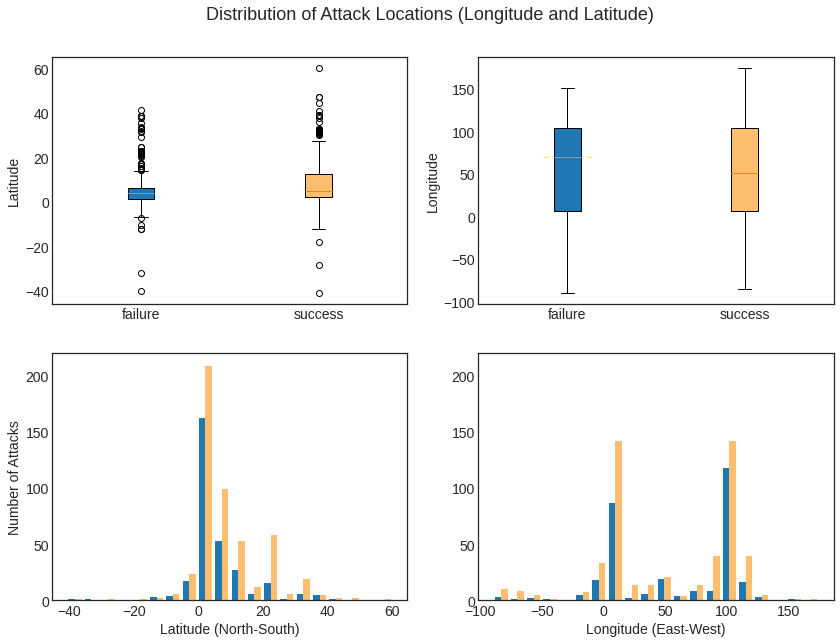

In [65]:
success = pirate_data[pirate_data["ATTACK SUCCESS"] == 1]
failure = pirate_data[pirate_data["ATTACK SUCCESS"] == 0]
labels = ["failure", "success"]
cols = [colors[1], colors[6]]

fig, axs = plt.subplots(2, 2, figsize = (14, 10))
fig.suptitle(x = 0.5, y = 0.95, t = 'Distribution of Attack Locations (Longitude and Latitude)', fontsize=18)

bplot1 = axs[0, 0].boxplot([failure["LAT"], success["LAT"]], vert = True, patch_artist=True, labels = labels)
axs[0, 0].set_ylabel("Latitude")

bplot2 = axs[0, 1].boxplot([failure["LONG"], success["LONG"]], vert = True, patch_artist=True, labels = labels)
axs[0, 1].set_ylabel("Longitude")

for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], cols):
        patch.set_facecolor(color)

axs[1, 0].hist([failure["LAT"], success["LAT"]], color = cols, bins = 20)
axs[1, 0].set_xlabel("Latitude (North-South)")
axs[1, 0].set_ylabel("Number of Attacks")
axs[1, 0].set_ylim(0,220)
axs[1, 1].hist([failure["LONG"], success["LONG"]], color = cols, bins = 20)
axs[1, 1].set_xlabel("Longitude (East-West)")
axs[1, 1].set_ylim(0,220);

### Attacks by month, weekday and time of day

We may also be able to understand our data set better from some visualizations of the time stamp related information.

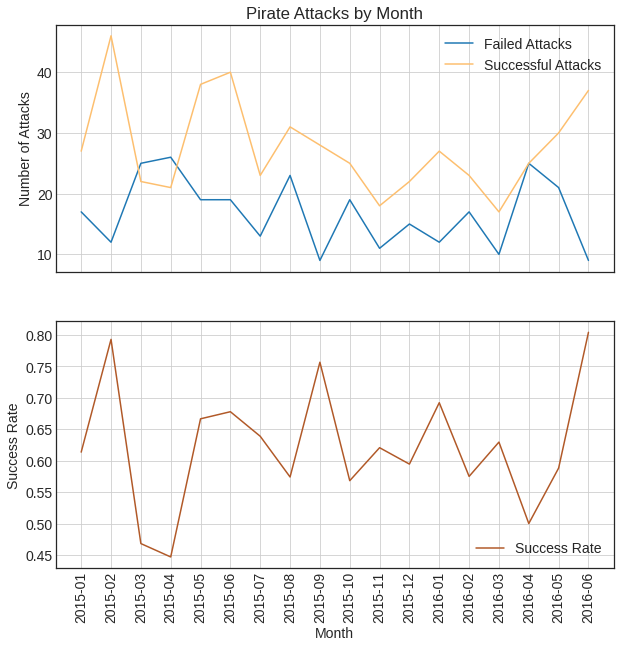

In [63]:
success_grouped = success.groupby(["YEAR_MONTH"]).sum()
failure_grouped = failure.groupby(["YEAR_MONTH"]).sum()
attack_success_rate = success_grouped["ATTACKS"] / (success_grouped["ATTACKS"] + failure_grouped["ATTACKS"])

fig, axs = plt.subplots(2, 1, sharex = True, figsize = (10, 10))

axs[0].plot(failure_grouped["ATTACKS"], label = "Failed Attacks", color = colors[1])
axs[0].plot(success_grouped["ATTACKS"], label = "Successful Attacks", color = colors[6])
axs[0].set_title("Pirate Attacks by Month")
axs[0].set_ylabel("Number of Attacks")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(attack_success_rate, label = "Success Rate", color = colors[11])
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Success Rate")
axs[1].grid(True)
axs[1].legend()
plt.xticks(rotation = 90);

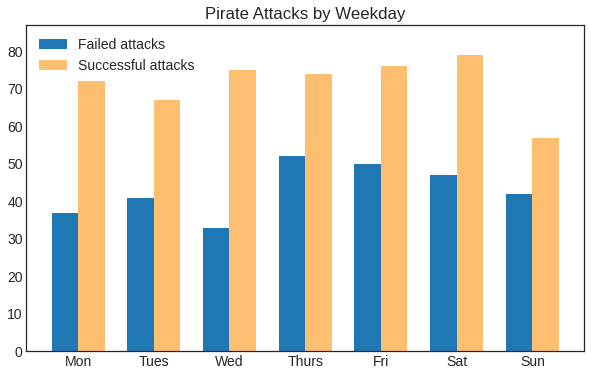

In [73]:
success_weekday_grouped = success.groupby("WEEKDAY").sum().reset_index()
failure_weekday_grouped = failure.groupby("WEEKDAY").sum().reset_index()

labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
width = 0.35
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize = (10, 6))

ax.bar(x-width/2, failure_weekday_grouped["ATTACKS"], width, color = colors[1], label = "Failed attacks")
ax.bar(x+width/2, success_weekday_grouped["ATTACKS"], width, color = colors[6], 
       label = "Successful attacks")

ax.set_title('Pirate Attacks by Weekday')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,87)
ax.legend(loc = 2);

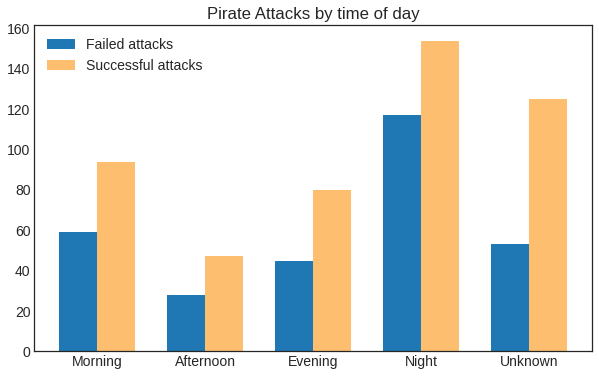

In [61]:
success_time_grouped = success.groupby("TIME OF DAY").sum().reset_index()
success_time_grouped["TIME OF DAY"] = pd.Categorical(success_time_grouped["TIME OF DAY"], categories=
    ['Morning','Afternoon','Evening','Night','Unknown'],
    ordered=True)
success_time_grouped = success_time_grouped.sort_values("TIME OF DAY").reset_index(drop = True)

failure_time_grouped = failure.groupby("TIME OF DAY").sum().reset_index()
failure_time_grouped["TIME OF DAY"] = pd.Categorical(failure_time_grouped["TIME OF DAY"], categories=
    ['Morning','Afternoon','Evening','Night','Unknown'],
    ordered=True)
failure_time_grouped = failure_time_grouped.sort_values("TIME OF DAY").reset_index(drop = True)

labels = ['Morning','Afternoon','Evening','Night','Unknown']
width = 0.35
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize = (10, 6))

ax.bar(x-width/2, failure_time_grouped["ATTACKS"], width, color = colors[1], label = "Failed attacks")
ax.bar(x+width/2, success_time_grouped["ATTACKS"], width, color = colors[6], label = "Successful attacks")

ax.set_title('Pirate Attacks by time of day')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend();

In [20]:
pirate_data.to_csv("data/pirate_data_visualized.csv")